In [1]:
import torch
# GPUが使用可能か判断
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

gpu is available


device(type='cuda')

In [ ]:
!pip install transformers[torch] datasets
!pip install fugashi
!pip install ipadic
!pip install sentencepiece

In [ ]:
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

In [2]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import torch
import random

In [3]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

In [4]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリから
# データを読み込む
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train", remove_neutral=False)
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation", remove_neutral=False)
# pprintで見やすく表示する
pprint(train_dataset)
pprint(valid_dataset)

Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 30000
})
Dataset({
    features: ['sentence', 'label', 'user_id', 'datetime'],
    num_rows: 2500
})


In [ ]:
# # 実験のためデータセットを縮小したい場合はコチラを有効化
# train_dataset = train_dataset.select(
#     random.sample(range(train_dataset.num_rows), k=500))
# valid_dataset = valid_dataset.select(
#     random.sample(range(valid_dataset.num_rows), k=500))
# pprint(train_dataset)
# pprint(valid_dataset)

In [5]:
# トークナイザのロード
model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
# トークナイズ処理
def preprocess_text(batch):
    encoded_batch = tokenizer(batch['sentence'], max_length=512)
    encoded_batch['labels'] = batch['label']
    return encoded_batch

In [7]:
encoded_train_dataset = train_dataset.map(
    preprocess_text,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text,
    remove_columns=valid_dataset.column_names,
)

In [11]:
# お試し
from pprint import pprint
pprint(encoded_train_dataset[0], width=200)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 3937, 28517, 26099, 15, 16, 3318, 12272, 640, 8, 1131, 28479, 31, 40, 2949, 7, 12, 1549, 5602, 3215, 3],
 'labels': 1,
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [12]:
# ミニバッチ構築
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
# お試し
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


In [14]:
# モデルの準備
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [15]:
# お試し
pprint(model.forward(**data_collator(encoded_train_dataset[0:4])))

{'logits': tensor([[ 0.0312, -0.2353, -0.0396],
        [ 0.1477, -0.1899, -0.1425],
        [ 0.0984, -0.1648, -0.1193],
        [ 0.1109, -0.0401, -0.1793]], grad_fn=<AddmmBackward0>),
 'loss': tensor(1.1080, grad_fn=<NllLossBackward0>)}


In [16]:
# 訓練の実行
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="constant",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [17]:
# メトリクスの定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.752800,0.666431,0.704400,0.705793
2,0.546800,0.708216,0.717200,0.709107
3,0.378500,0.776293,0.711600,0.712549


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

TrainOutput(global_step=2814, training_loss=0.5593940827045021, metrics={'train_runtime': 196.8913, 'train_samples_per_second': 457.105, 'train_steps_per_second': 14.292, 'total_flos': 3905861130112032.0, 'train_loss': 0.5593940827045021, 'epoch': 3.0})

In [23]:
# epoch: 100, early stopping
# 訓練の実行
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="constant",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=100,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="eval_loss",  # 最良のモデルを決定する評価指標
    greater_is_better=False,            # eval_lossは小さいほどよい
    fp16=True,  # 自動混合精度演算の有効化
)

In [24]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.244300,1.024115,0.706000,0.709655
2,0.121400,1.351977,0.700800,0.699294
3,0.241800,0.982863,0.704800,0.707673
4,0.161200,1.054734,0.707200,0.709262
5,0.123000,1.308562,0.710400,0.711905
6,0.102400,1.450015,0.709200,0.711764


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

TrainOutput(global_step=5628, training_loss=0.16568725466643486, metrics={'train_runtime': 394.1545, 'train_samples_per_second': 7611.228, 'train_steps_per_second': 237.978, 'total_flos': 7795919010571776.0, 'train_loss': 0.16568725466643486, 'epoch': 6.0})

In [34]:
history_df = pd.DataFrame(trainer.state.log_history)
history_df.to_csv('base_line/baseline_history.csv')

In [29]:
from sklearn.linear_model import LinearRegression

def linear_regression(history_df):
    y = history_df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    linear = LinearRegression().fit(x, y)
    return linear

In [36]:
import matplotlib.pyplot as plt

def show_graph(df, suptitle, regression, output='output.png'):
    suptitle_size = 23
    graph_title_size = 20
    legend_size = 18
    ticks_size = 13
    # 学習曲線
    fig = plt.figure(figsize=(20, 5))
    # plt.suptitle(','.join([f'{e}: {parameters[e]}' for e in parameters.keys()]), fontsize=suptitle_size)
    plt.suptitle(suptitle, fontsize=suptitle_size)
    # Train Loss
    plt.subplot(131)
    plt.title('Train Loss', fontsize=graph_title_size)
    plt.plot(df['loss'].dropna(), label='train')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    # Validation Loss
    plt.subplot(132)
    reg_str = f'$y={round(regression.coef_[0],5)}*x+{round(regression.intercept_,3)}$'
    plt.title(f'Val Loss', fontsize=graph_title_size)
    y = df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    pred = regression.coef_ * x.ravel() + regression.intercept_  # 線形回帰直線
    plt.plot(y, color='tab:orange', label='val')
    plt.plot(pred, color='green', label='pred')
    plt.legend(fontsize=legend_size)
    plt.xlabel(reg_str, fontsize=ticks_size)
    plt.yticks(fontsize=ticks_size)
    # Accuracy/F1
    plt.subplot(133)
    plt.title('eval Accuracy/F1', fontsize=graph_title_size)
    plt.plot(df['eval_accuracy'].dropna(), label='accuracy')
    plt.plot(df['eval_f1'].dropna(), label='F1')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    plt.tight_layout()
    # plt.show()
    plt.savefig(output)

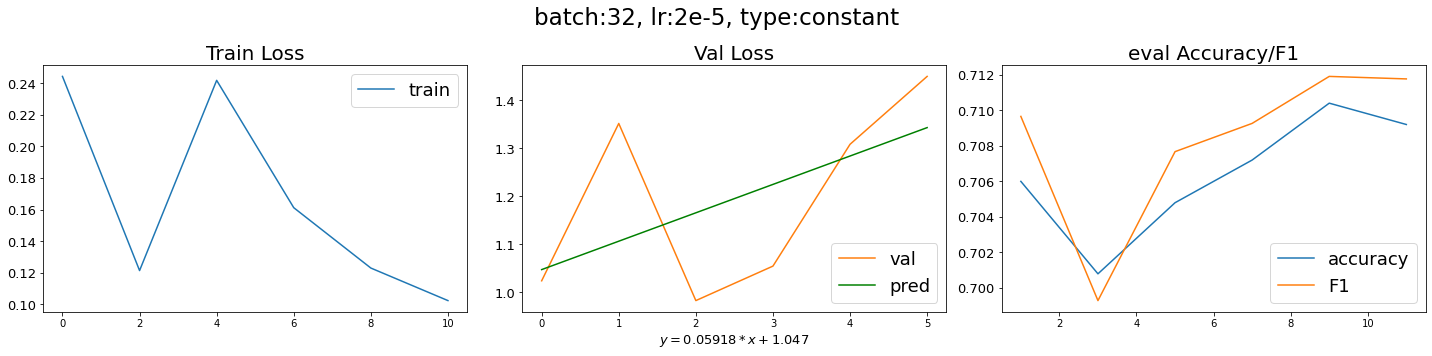

In [37]:
# 結果を表示
suptitle = 'batch:32, lr:2e-5, type:constant'
reg = linear_regression(history_df)
show_graph(history_df, suptitle, reg, 'base_line/output.png')